In [154]:
import torch
import pennylane as qml

from qulearn.hat_basis import HatBasis
from qulearn.qlayer import (HatBasisQFE,
                            CircuitLayer,
                            MeasurementLayer,
                            MeasurementType)
from qulearn.mps import HatBasisMPS

In [140]:
import torch
import tntorch as tn
def zkron(t1, t2):
    c1 = t1.cores
    c2 = t2.cores
    c3 = [torch.kron(A, B) for A, B in zip(c1, c2)]
    
    t3 = tn.Tensor(c3)
    return t3


def kron(t1, t2):
    c1 = t1.cores
    c2 = t2.cores
    c3 = c1 + c2
    t3 = tn.Tensor(c3)
    
    return t3

In [141]:
import tntorch as tn
import numpy as np

t1 = tn.randn([2]*3)
t2 = tn.ones([2]*3)

T1 = t1.numpy().reshape((2**3))
T2 = t2.numpy().reshape((2**3))

t3 = kron(t1, t2)
T3 = t3.numpy().reshape((2**6))

T3_ = np.kron(T1, T2)
delta = abs(T3_ - T3)
delta = np.linalg.norm(delta)
print(delta)

t4 = zkron(t1, t2)
T4 = t4.numpy().reshape((2**6))

print(t4)
print(T3)
print("=========")
print(T4)

0.0
3D TT tensor:

  4   4   4
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   2   2   1

[-1.5204161  -1.5204161  -1.5204161  -1.5204161  -1.5204161  -1.5204161
 -1.5204161  -1.5204161  -0.07047679 -0.07047679 -0.07047679 -0.07047679
 -0.07047679 -0.07047679 -0.07047679 -0.07047679  8.780638    8.780638
  8.780638    8.780638    8.780638    8.780638    8.780638    8.780638
 -1.424307   -1.424307   -1.424307   -1.424307   -1.424307   -1.424307
 -1.424307   -1.424307   -2.357471   -2.357471   -2.357471   -2.357471
 -2.357471   -2.357471   -2.357471   -2.357471    0.4497826   0.4497826
  0.4497826   0.4497826   0.4497826   0.4497826   0.4497826   0.4497826
 -1.8961011  -1.8961011  -1.8961011  -1.8961011  -1.8961011  -1.8961011
 -1.8961011  -1.8961011   0.48295355  0.48295355  0.48295355  0.48295355
  0.48295355  0.48295355  0.48295355  0.48295355]
[-1.5204161  -1.5204161  -0.07047679 -0.07047679 -1.5204161  -1.5204161
 -0.07047679 -0.07047679  8.780638    8.780638   -1.424307   -1.424307
  8.7

In [142]:
print(t1.numpy().reshape((2**3)))
print(t2.numpy().reshape((2**3)))
print(T3_)
print(T4)

[-1.5204161  -0.07047679  8.780638   -1.424307   -2.357471    0.4497826
 -1.8961011   0.48295355]
[1. 1. 1. 1. 1. 1. 1. 1.]
[-1.5204161  -1.5204161  -1.5204161  -1.5204161  -1.5204161  -1.5204161
 -1.5204161  -1.5204161  -0.07047679 -0.07047679 -0.07047679 -0.07047679
 -0.07047679 -0.07047679 -0.07047679 -0.07047679  8.780638    8.780638
  8.780638    8.780638    8.780638    8.780638    8.780638    8.780638
 -1.424307   -1.424307   -1.424307   -1.424307   -1.424307   -1.424307
 -1.424307   -1.424307   -2.357471   -2.357471   -2.357471   -2.357471
 -2.357471   -2.357471   -2.357471   -2.357471    0.4497826   0.4497826
  0.4497826   0.4497826   0.4497826   0.4497826   0.4497826   0.4497826
 -1.8961011  -1.8961011  -1.8961011  -1.8961011  -1.8961011  -1.8961011
 -1.8961011  -1.8961011   0.48295355  0.48295355  0.48295355  0.48295355
  0.48295355  0.48295355  0.48295355  0.48295355]
[-1.5204161  -1.5204161  -0.07047679 -0.07047679 -1.5204161  -1.5204161
 -0.07047679 -0.07047679  8.780638  

In [143]:
import tntorch
try:
    from typing import TypeAlias
except ImportError:
    from typing_extensions import TypeAlias
MPS: TypeAlias = tntorch.tensor.Tensor
Tensor: TypeAlias = torch.Tensor

class LinearBasis2DMPS:
    def __init__(self, basis: HatBasis, zorder: bool = False) -> None:
        self.basis = basis

        num_qubits = 2*math.log2(basis.num_nodes)
        if not num_qubits.is_integer():
            raise ValueError(
                f"Number of nodes ({basis.num_nodes}) " "must be a power of 2."
            )

        self.num_sites = int(num_qubits)
        self.basis1Dmps = HatBasisMPS(basis)
        self.zorder = zorder
        
    def __call__(self, x: Tensor) -> MPS:
        """
        Constructs the MPS of the hat basis evaluated at a given point x.

        :param x: The input at which to evaluate the hat basis.
        :type x: Tensor
        :returns: The MPS at point x.
        :rtype: MPS
        """

        return self.eval(x)

    def eval(self, x: Tensor) -> MPS:
        """
        Constructs the MPS of the hat basis evaluated at a given point x.

        :param x: The input at which to evaluate the hat basis.
        :type x: Tensor
        :returns: The MPS at point x.
        :rtype: MPS
        """
        
        mpsx = self.basis1Dmps(x[0])
        mpsy = self.basis1Dmps(x[1])
        
        if self.zorder:
            return zkron(mpsx, mpsy)
        
        return kron(mpsx, mpsy)

In [144]:
try:
    from typing import TypeAlias
except ImportError:
    from typing_extensions import TypeAlias

from typing import Iterable, Any, Optional, Union, Dict

from qulearn.mps import HatBasisMPS, MPSQGates

Wires: TypeAlias = Union[int, Iterable[Any]]

class Linear2DBasisQFE(CircuitLayer):
    """
    Layer for the 1D hat basis quantum feature embedding.

    :param basis: The hat basis class.
    :type basis: HatBasis
    :param wires: The wires to be used by the layer
    :type wires: Wires
    :param sqrt: Set flag to take square roots before applying hat basis.
    :type sqrt: bool
    :param normalize: Set flag to normalize basis vector before embedding.
    :type normalize: bool
    """

    def __init__(
        self,
        wires: Wires,
        basis: HatBasis,
        sqrt: bool = False,
        normalize: bool = False,
        zorder: bool = False,
    ) -> None:
        super().__init__(wires)
        self.basis = basis
        self.sqrt = sqrt
        self.normalize = normalize
        self.norm = 1.0
        self.hbmps = HatBasisMPS(basis)
        self.zorder = zorder

    def circuit(self, x: Tensor) -> None:
        """
        Define the quantum circuit for this layer.

        :param x: Input tensor that is passed to the quantum circuit.
        :type x: Tensor
        """

        x1 = x[0]
        x2 = x[1]
        position1 = int(self.basis.position(x1))
        position2 = int(self.basis.position(x2))
        a1, b1 = self.basis.nonz_vals(x1)
        a2, b2 = self.basis.nonz_vals(x2)

        if self.sqrt:
            # sometimes the values are close to 0 and negative
            a1 = torch.sqrt(torch.abs(a1))
            b1 = torch.sqrt(torch.abs(b1))
            a2 = torch.sqrt(torch.abs(a2))
            b2 = torch.sqrt(torch.abs(b2))

        # TODO: cover the case where x or y are outside of bounds

        val1 = a1*a2
        val2 = a1*b2
        val3 = a2*b1
        val4 = a2*b2
        self.norm = torch.sqrt(val1**2 + val2**2 + val3**2 +val4**2).item()
        
        if self.normalize:
            a1 /= torch.sqrt(self.norm)
            b1 /= torch.sqrt(self.norm)
            a2 /= torch.sqrt(self.norm)
            b2 /= torch.sqrt(self.norm)

        # for compatibility (TODO: remove)
        first1 = a1.item()
        second1 = b1.item()
        first2 = a2.item()
        second2 = a2.item()

        mps1 = self.hbmps.mps_hatbasis(first1, second1, position1)
        mps2 = self.hbmps.mps_hatbasis(first2, second2, position2)

        if self.zorder:
            mps = zkron(mps2, mps1)
        else:
            mps = kron(mps1, mps2)
            
        mpsgates = MPSQGates(mps)

        s = mpsgates.max_rank_power
        Us = mpsgates.qgates()
        N = len(Us)
        count = 0
        for k in range(N - 1, -1, -1):
            wires_idx = list(
                range(self.num_wires - count - s - 1, self.num_wires - count)
            )
            subwires = [self.wires[idx] for idx in wires_idx]
            qml.QubitUnitary(Us[k], wires=subwires, unitary_check=False)

            count += 1
    
    def compute_norm(self, x: Tensor) -> float:

        x1 = x[0]
        x2 = x[1]
        a1, b1 = self.basis.nonz_vals(x1)
        a2, b2 = self.basis.nonz_vals(x2)

        if self.sqrt:
            # sometimes the values are close to 0 and negative
            a1 = torch.sqrt(torch.abs(a1))
            b1 = torch.sqrt(torch.abs(b1))
            a2 = torch.sqrt(torch.abs(a2))
            b2 = torch.sqrt(torch.abs(b2))

        # TODO: cover the case where x or y are outside of bounds

        val1 = a1*a2
        val2 = a1*b2
        val3 = a2*b1
        val4 = a2*b2
        self.norm = torch.sqrt(val1**2 + val2**2 + val3**2 +val4**2).item()
        
        return self.norm

In [145]:
num_qubits = 3
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

embed = Linear2DBasisQFE(wires=2*num_qubits, basis=hat_basis, sqrt=True, normalize=False)
obs = qml.PauliZ(0)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0, 0.0])
print(drawer(x))

0: ─────────────────────────────╭U(M3)─┤  <Z>
1: ──────────────────────╭U(M0)─╰U(M3)─┤     
2: ───────────────╭U(M2)─╰U(M0)────────┤     
3: ────────╭U(M1)─╰U(M2)───────────────┤     
4: ─╭U(M0)─╰U(M1)──────────────────────┤     
5: ─╰U(M0)─────────────────────────────┤     


In [164]:
import numpy as np

num_qubits = 2
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=False, normalize=False)

dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def circuit(x):
    embed.circuit(x)
    return np.real(qml.state())


x = torch.tensor([0.15])
out = circuit(x)
out = np.real(out)
print(out)

[0.         0.27500004 0.72499996 0.        ]


In [181]:
hbmps = HatBasisMPS(hat_basis)
x = torch.tensor([-0.333])
y = torch.tensor([0.])
mpsx = hbmps(x)
mpsy = hbmps(y)
mps = kron(mpsy, mpsx)
print(mpsx.numpy().reshape(-1))
print(mpsy.numpy().reshape(-1))
print(mps.numpy().reshape(-1))

[0.0000000e+00 9.9950004e-01 4.9996376e-04 0.0000000e+00]
[0.         0.50000006 0.49999997 0.        ]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.9975008e-01 2.4998191e-04 0.0000000e+00 0.0000000e+00 4.9974999e-01
 2.4998185e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


In [217]:
import numpy as np

num_qubits = 2
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

embed = Linear2DBasisQFE(wires=2*num_qubits, basis=hat_basis, sqrt=False, normalize=False)

dev = qml.device("default.qubit", wires=2*num_qubits)
@qml.qnode(dev)
def circuit(x):
    embed.circuit(x)
    return np.real(qml.state())

x = torch.tensor([-0.95, -0.333])
out = np.real(circuit(x))
print(out)
print(out[5])

[0.         0.92453752 0.92453752 0.         0.         0.07496252
 0.07496252 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
0.07496251607264348


tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9592, -0.9592, -0.9592,  ..., -0.9592, -0.9592, -0.9592],
        [-0.9184, -0.9184, -0.9184,  ..., -0.9184, -0.9184, -0.9184],
        ...,
        [ 0.9184,  0.9184,  0.9184,  ...,  0.9184,  0.9184,  0.9184],
        [ 0.9592,  0.9592,  0.9592,  ...,  0.9592,  0.9592,  0.9592],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])
tensor([[-1.0000, -0.9592, -0.9184,  ...,  0.9184,  0.9592,  1.0000],
        [-1.0000, -0.9592, -0.9184,  ...,  0.9184,  0.9592,  1.0000],
        [-1.0000, -0.9592, -0.9184,  ...,  0.9184,  0.9592,  1.0000],
        ...,
        [-1.0000, -0.9592, -0.9184,  ...,  0.9184,  0.9592,  1.0000],
        [-1.0000, -0.9592, -0.9184,  ...,  0.9184,  0.9592,  1.0000],
        [-1.0000, -0.9592, -0.9184,  ...,  0.9184,  0.9592,  1.0000]])


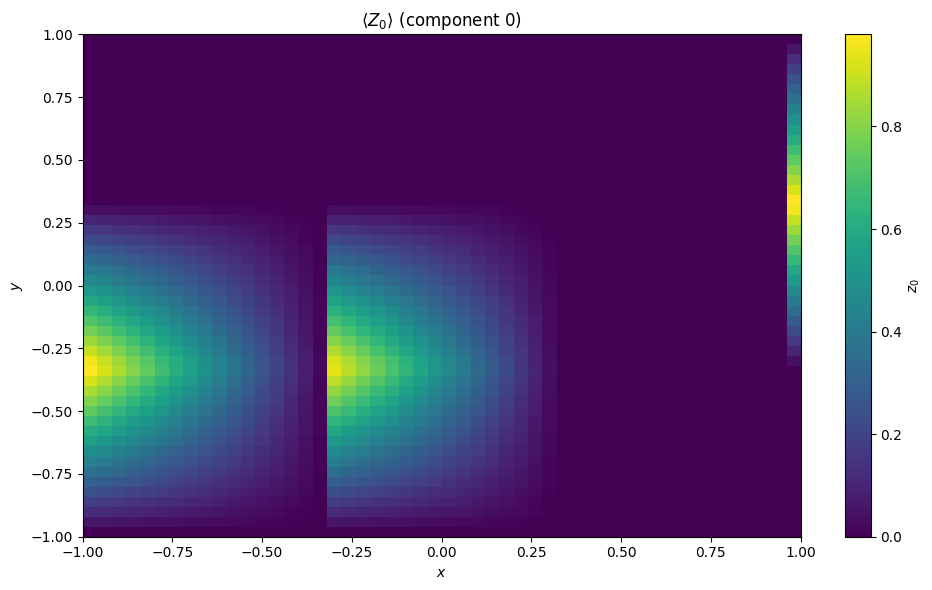

In [226]:
import torch
import matplotlib.pyplot as plt

num_pnts = 50

# Generate a grid of x and y values
x = torch.linspace(-1.0, 1.0, num_pnts)
y = torch.linspace(-1.0, 1.0, num_pnts)
X, Y = torch.meshgrid(x, y)
Z = torch.empty(num_pnts, num_pnts)

print(X)
print(Y)

# Evaluate the circuit at each point in the grid and extract the j-th component
idx = 5
for i in range(num_pnts):
    for k in range(num_pnts):
        xy = torch.tensor([X[i, k], Y[i, k]], dtype=torch.float32)
        out = circuit(xy)[idx]
        Z[i, k] = torch.tensor(out)
# Convert tensors to numpy arrays for plotting
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()

# Create a 2D heatmap plot
plt.figure(figsize=(10, 6))
plt.imshow(Z, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis', aspect='auto')

# Add labels and title
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f"$\\langle Z_0\\rangle$ (component {j})")

# Add a color bar which maps values to colors
plt.colorbar(label=f'$z_{j}$')

# Save the figure
plt.tight_layout()

# Show the plot
plt.show()

In [147]:
import torch
import matplotlib.pyplot as plt
import pennylane as qml

num_pnts = 100

# Generate a grid of x and y values
x = torch.linspace(-1.0, 1.0, num_pnts)
y = torch.linspace(-1.0, 1.0, num_pnts)
X, Y = torch.meshgrid(x, y)
Z = torch.empty(num_pnts, num_pnts)

# Evaluate the circuit at each point in the grid and extract the j-th component
idx = 36
for i in range(num_pnts):
    for k in range(num_pnts):
        xy = torch.tensor([X[i, k], Y[i, k]], dtype=torch.float32)
        out = circuit(xy)[idx]
        Z[i, k] = torch.tensor(out)

# Convert tensors to numpy arrays for plotting
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel(f'$z_{j}$')
ax.set_title(f"$\langle Z_0\\rangle$ (component {j})")

ax.view_init(elev=30, azim=0)

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Save the figure
plt.tight_layout()

# Show the plot
plt.show()

IndexError: index 36 is out of bounds for axis 0 with size 16

In [ ]:
num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts).unsqueeze(-1)
yvals = model(xvals)

plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle Z_0\\rangle$")
plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define the number of points in each dimension
num_pnts = 50

# Generate a grid of x and y values
x = torch.linspace(-1.0, 1.0, num_pnts)
y = torch.linspace(-1.0, 1.0, num_pnts)
X, Y = torch.meshgrid(x, y)
Z = torch.empty(num_pnts, num_pnts)

# Evaluate the model at each point in the grid
for i in range(num_pnts):
    for j in range(num_pnts):
        xy = torch.tensor([[X[i, j], Y[i, j]]])
        Z[i, j] = model(xy).item()

# Convert tensors to numpy arrays for plotting
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title("$\langle Z_0\\rangle$")

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Save the figure
plt.tight_layout()

# Show the plot
plt.show()